In [2]:
import matplotlib.pyplot as plt
from mne import Epochs, pick_types, events_from_annotations
from mne.io import read_raw_nirx
from mne.preprocessing import ICA
from itertools import compress
from mne.preprocessing.nirs import beer_lambert_law, scalp_coupling_index, source_detector_distances, optical_density
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [3]:
event_dict = {'left': 1, 'right': 2, 'r_pinch': 3, 'rest': 4, 'r_stop': 5}

In [18]:
raw = read_raw_nirx('nirs')
raw_od = optical_density(raw)

Loading nirs
Reading 0 ... 29272  =      0.000 ...  3746.816 secs...


C:\Users\Alberto\AppData\Local\Temp\ipykernel_8596\2156314533.py:1: RuntimeWarning: Extraction of measurement date from NIRX file failed. This can be caused by files saved in certain locales (currently only ['en_US.utf8', 'de_DE', 'fr_FR', 'it_IT'] supported). Please report this as a github issue. The date is being set to January 1st, 2000, instead of '"29 Nov 2022""13:50:29.582"'.
  raw = read_raw_nirx('nirs')


Compute Scalp Coupling

In [19]:
sci = scalp_coupling_index(raw_od)
fig, ax = plt.subplots()
ax.hist(sci)
ax.set(xlabel='Scalp Coupling Index', ylabel='Count', xlim=[0, 1])

[Text(0.5, 0, 'Scalp Coupling Index'), Text(0, 0.5, 'Count'), (0.0, 1.0)]

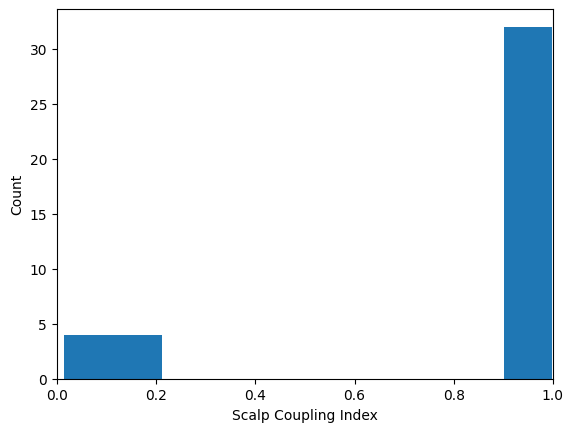

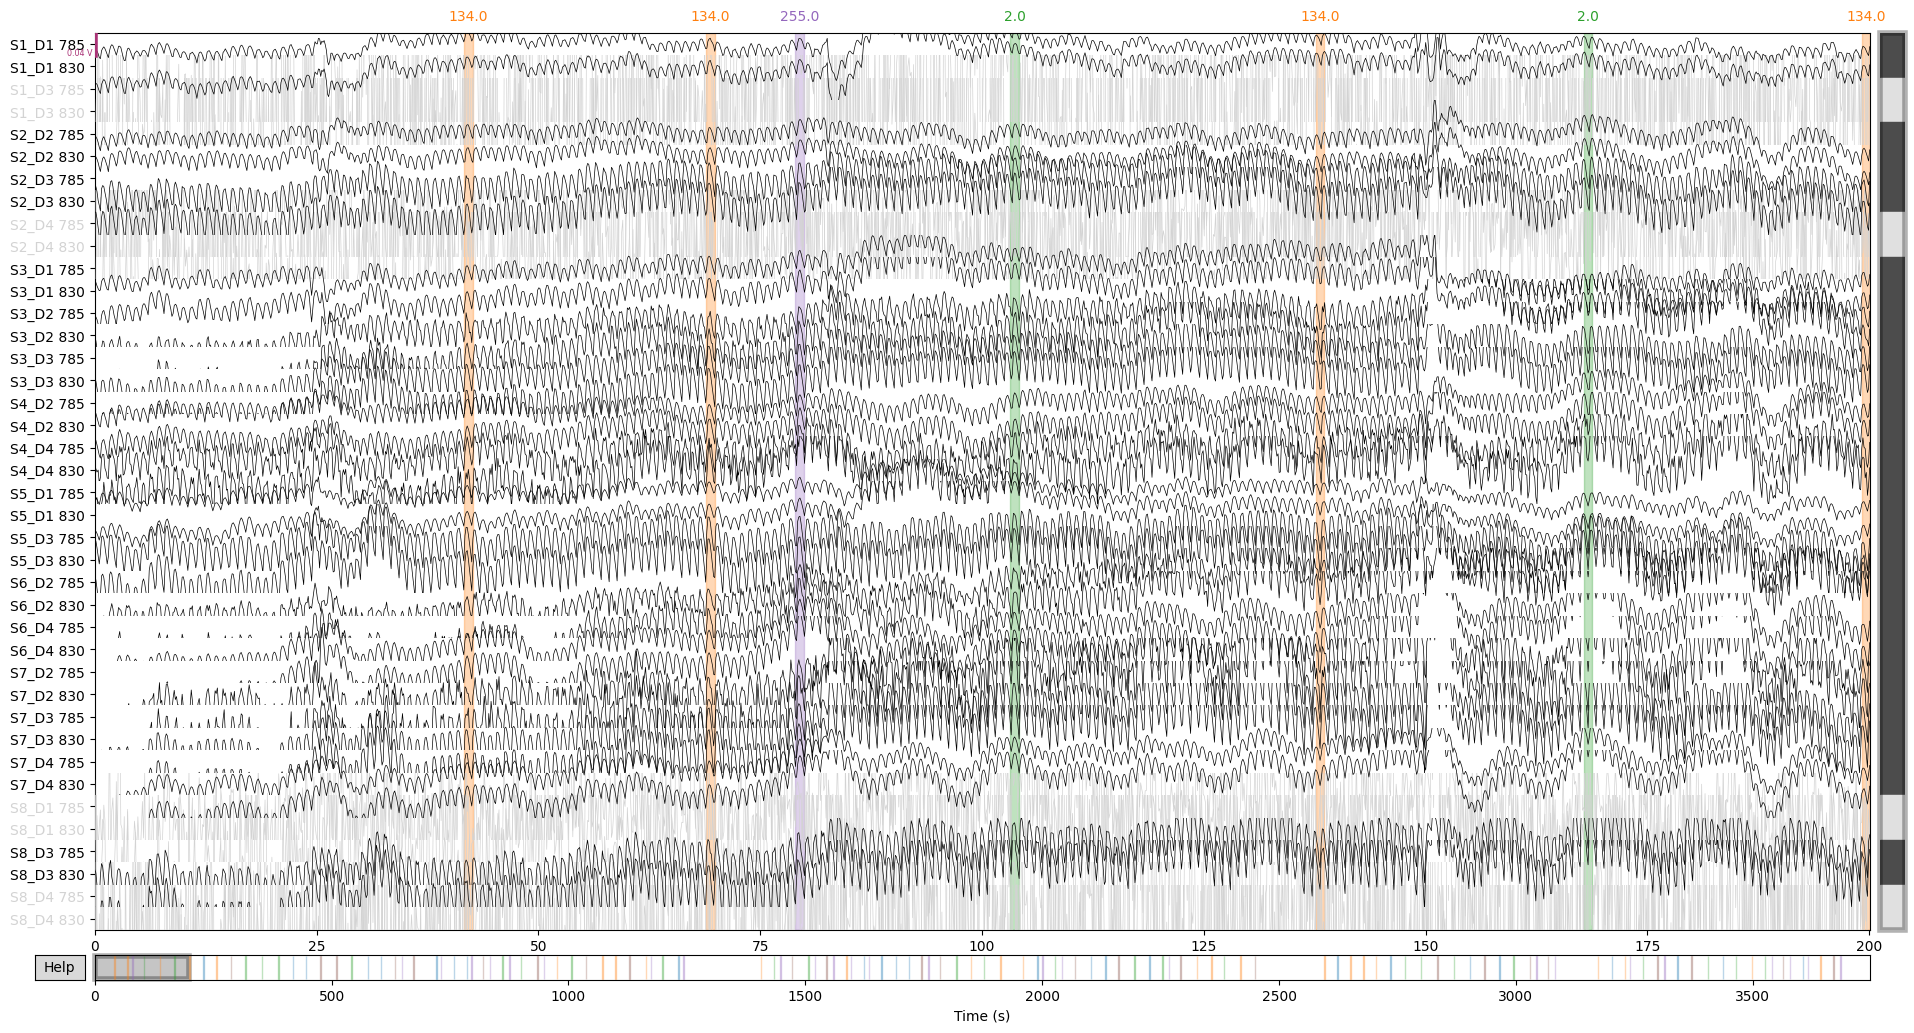

In [20]:
raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.5))
raw_od.plot(n_channels=40, duration=200)
print()

Compute Haemoglobin 

In [21]:
raw_hmo = beer_lambert_law(raw_od, ppf=0.1)


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 32.768 (s)


C:\Users\Alberto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


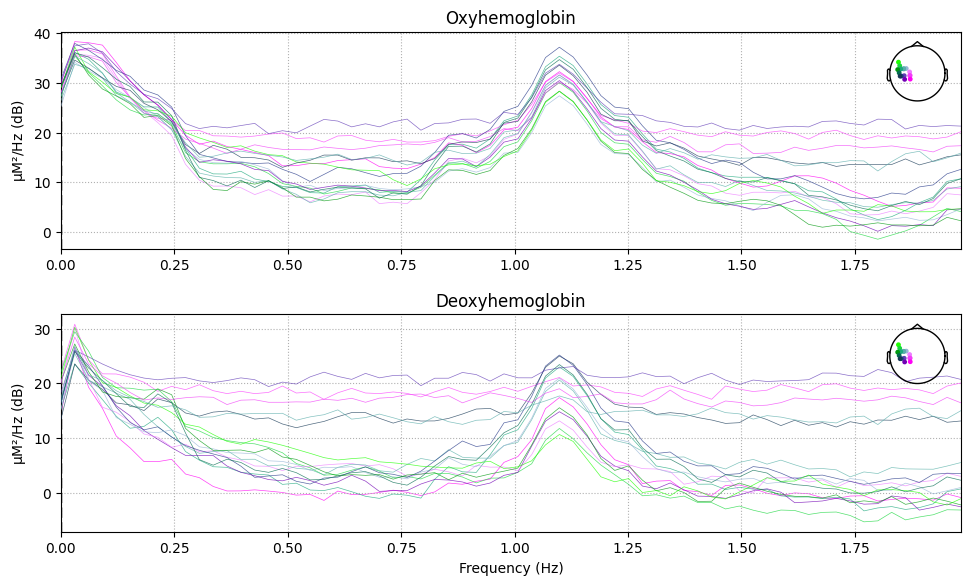

In [22]:
print()
raw_hmo.plot_psd(average=False, tmax=1200 ,fmax=2, )

Bandpass filter

In [23]:
print()
raw_hmo = raw_hmo.filter(0.05, 0.5, h_trans_bandwidth=0.2, l_trans_bandwidth=0.02, n_jobs=8)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.60 Hz)
- Filter length: 1291 samples (165.248 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.0s finished


In [24]:
event, event_id = events_from_annotations(raw_hmo)
epochs = Epochs(raw_hmo, event, event_id=event_dict,
        tmin=-5, tmax=20,
        proj=True, baseline=(-3,0), preload=True,
        detrend=None, verbose=True)

Used Annotations descriptions: ['130.0', '134.0', '2.0', '255.0', '4.0']
Not setting metadata
127 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 127 events and 196 original time points ...
0 bad epochs dropped


Removing Artifacts

In [25]:
epochs.info['bads'] += ['S1_D3 hbo', 'S2_D4 hbo', 'S8_D4 hbr', 'S1_D3 hbr', 'S8_D4 hbo'] 

In [26]:
ica = ICA(n_components=10)
ica.fit(epochs)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 10 components


C:\Users\Alberto\AppData\Local\Temp\ipykernel_8596\1728871398.py:2: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Fitting ICA took 0.3s.


<ICA | epochs decomposition, method: fastica (fit in 25 iterations on 24892 samples), 10 ICA components (32 PCA components available), channel types: hbo, hbr, no sources marked for exclusion>

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
50 matching events found
No baseline correction applied
0 projection i

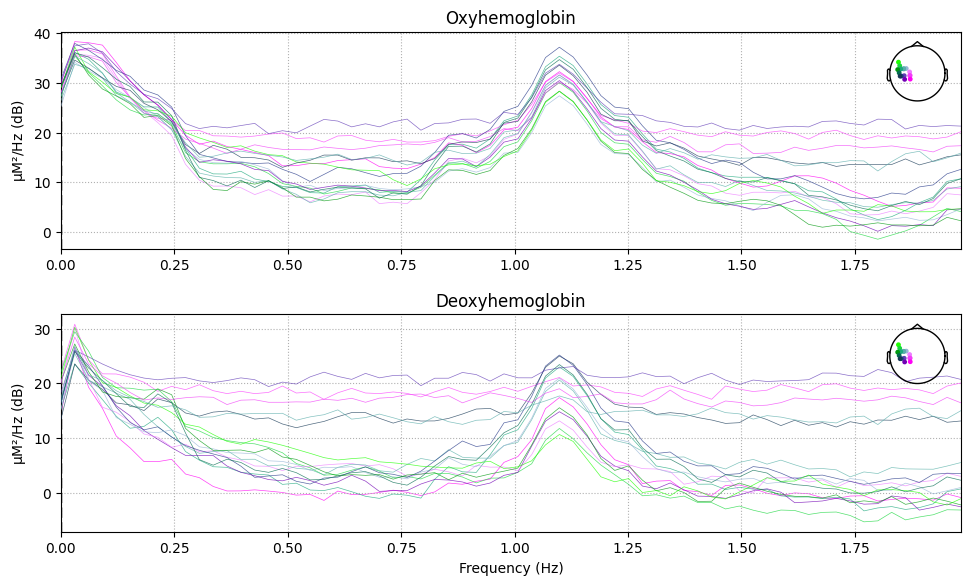

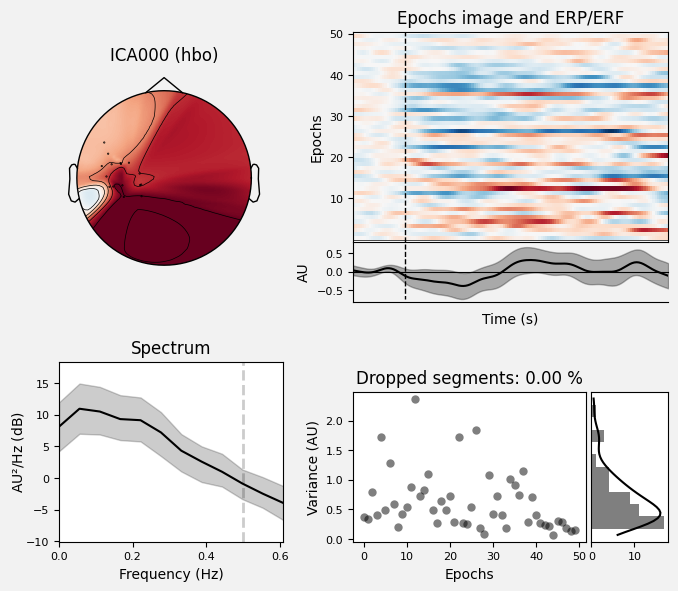

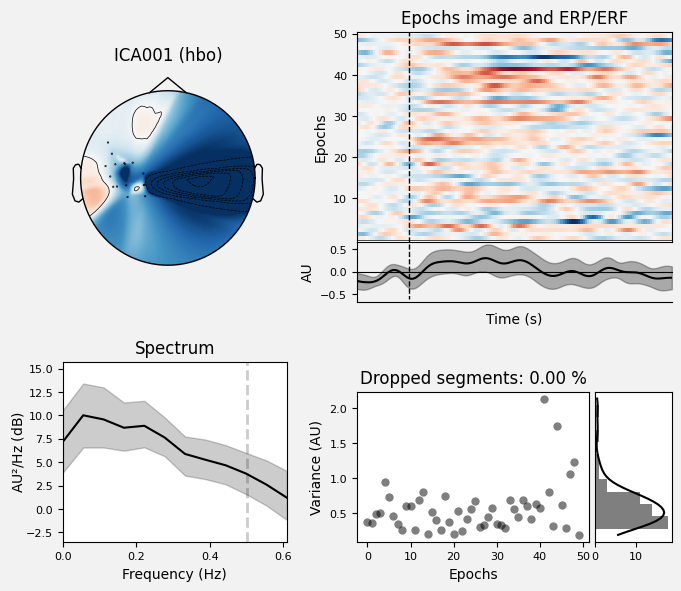

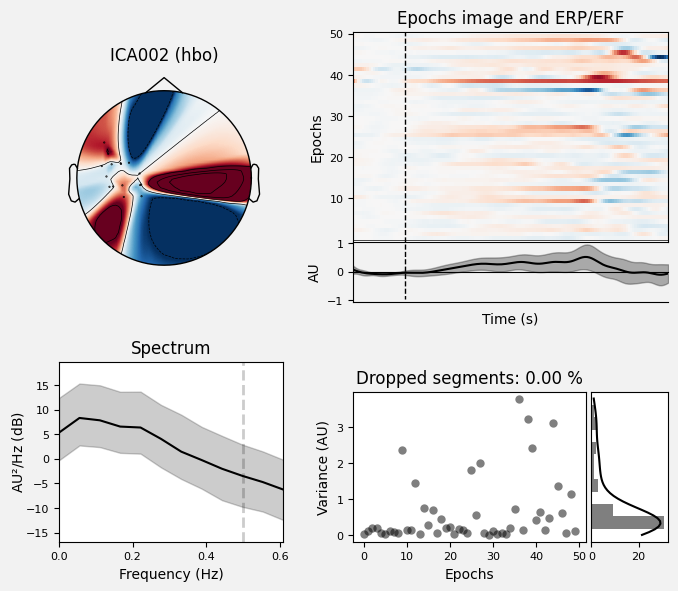

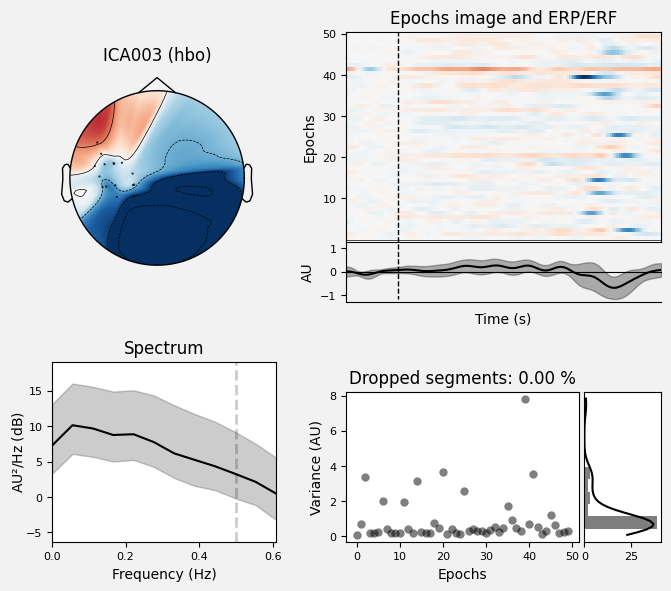

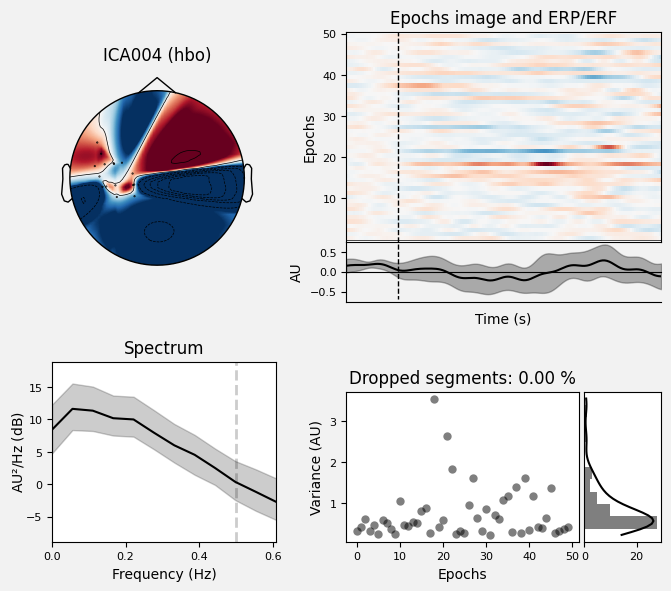

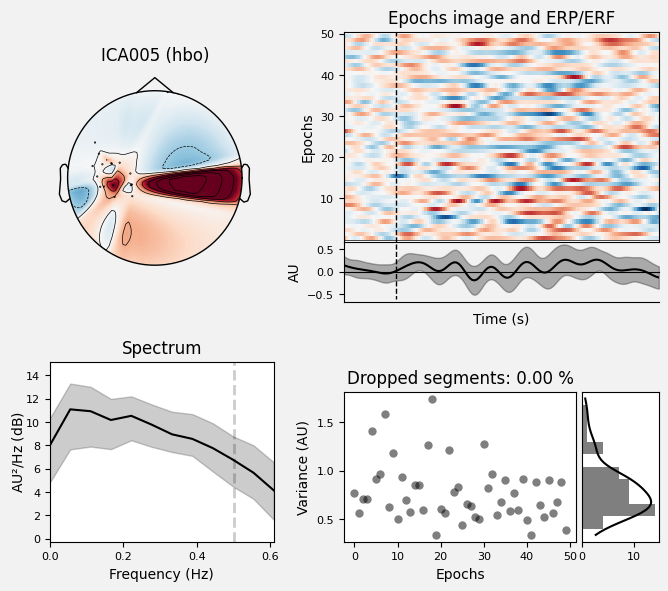

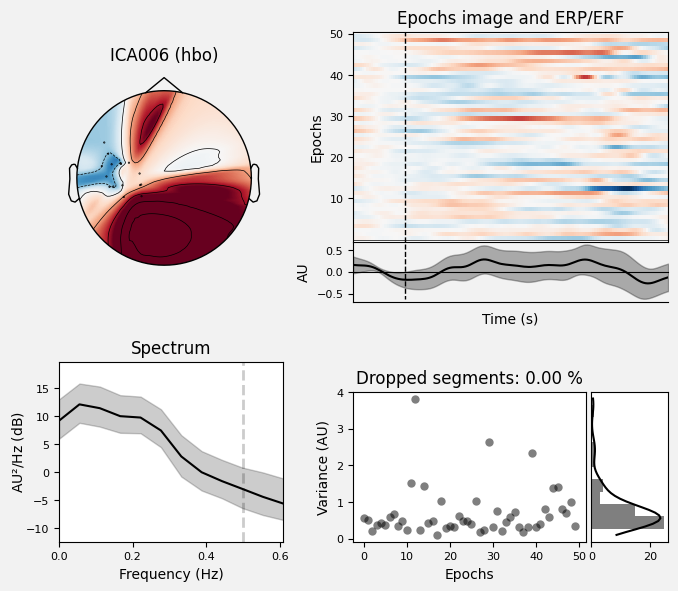

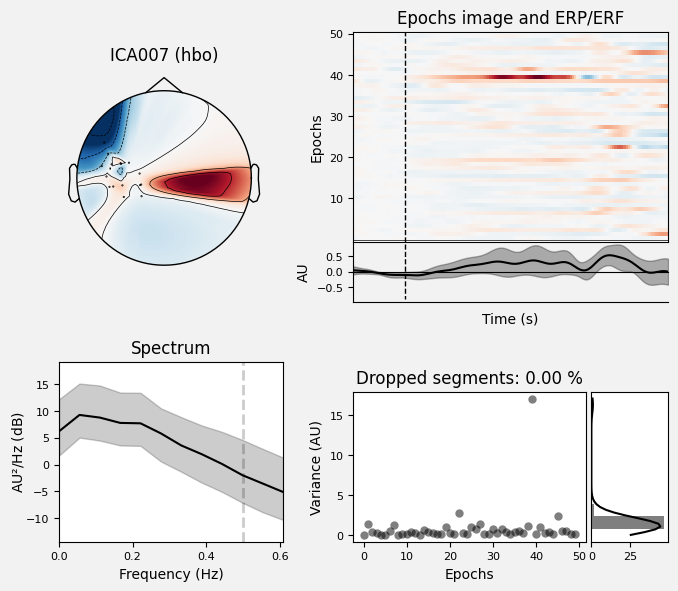

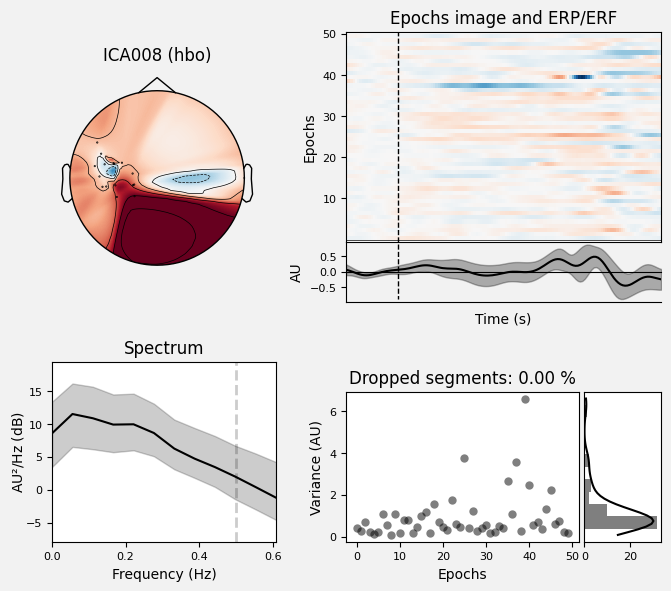

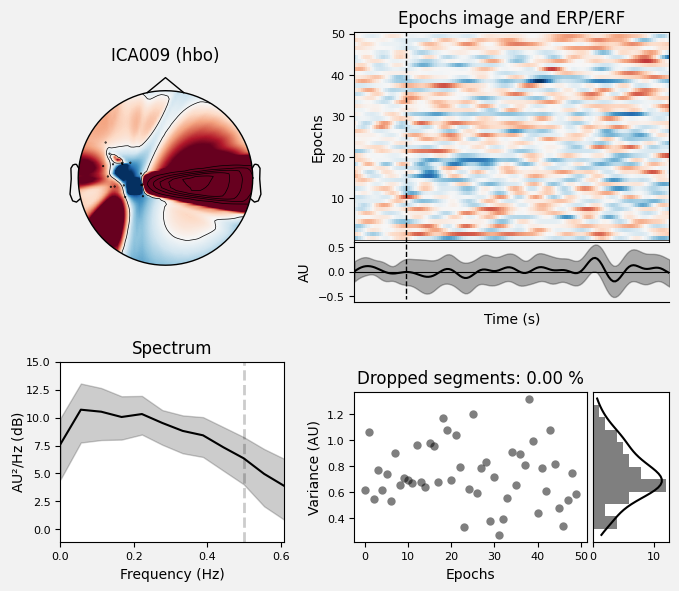

In [27]:
ica.plot_properties(
    epochs['left','right'].copy().crop(-3,15), 
    picks = [0,1,2,3,4,5,6,7,8,9], 
    log_scale = False)
print()

In [28]:
ica.apply(epochs, exclude=[3,9,7,6,5])

Applying ICA to Epochs instance
    Transforming to ICA space (10 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components


C:\Users\Alberto\AppData\Local\Temp\ipykernel_8596\1793082048.py:1: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs, exclude=[3,9,7,6,5])


<Epochs |  127 events (all good), -4.992 - 19.968 sec, baseline -3 – 0 sec, ~7.6 MB, data loaded,
 'left': 25
 'right': 25
 'r_pinch': 26
 'rest': 26
 'r_stop': 25>

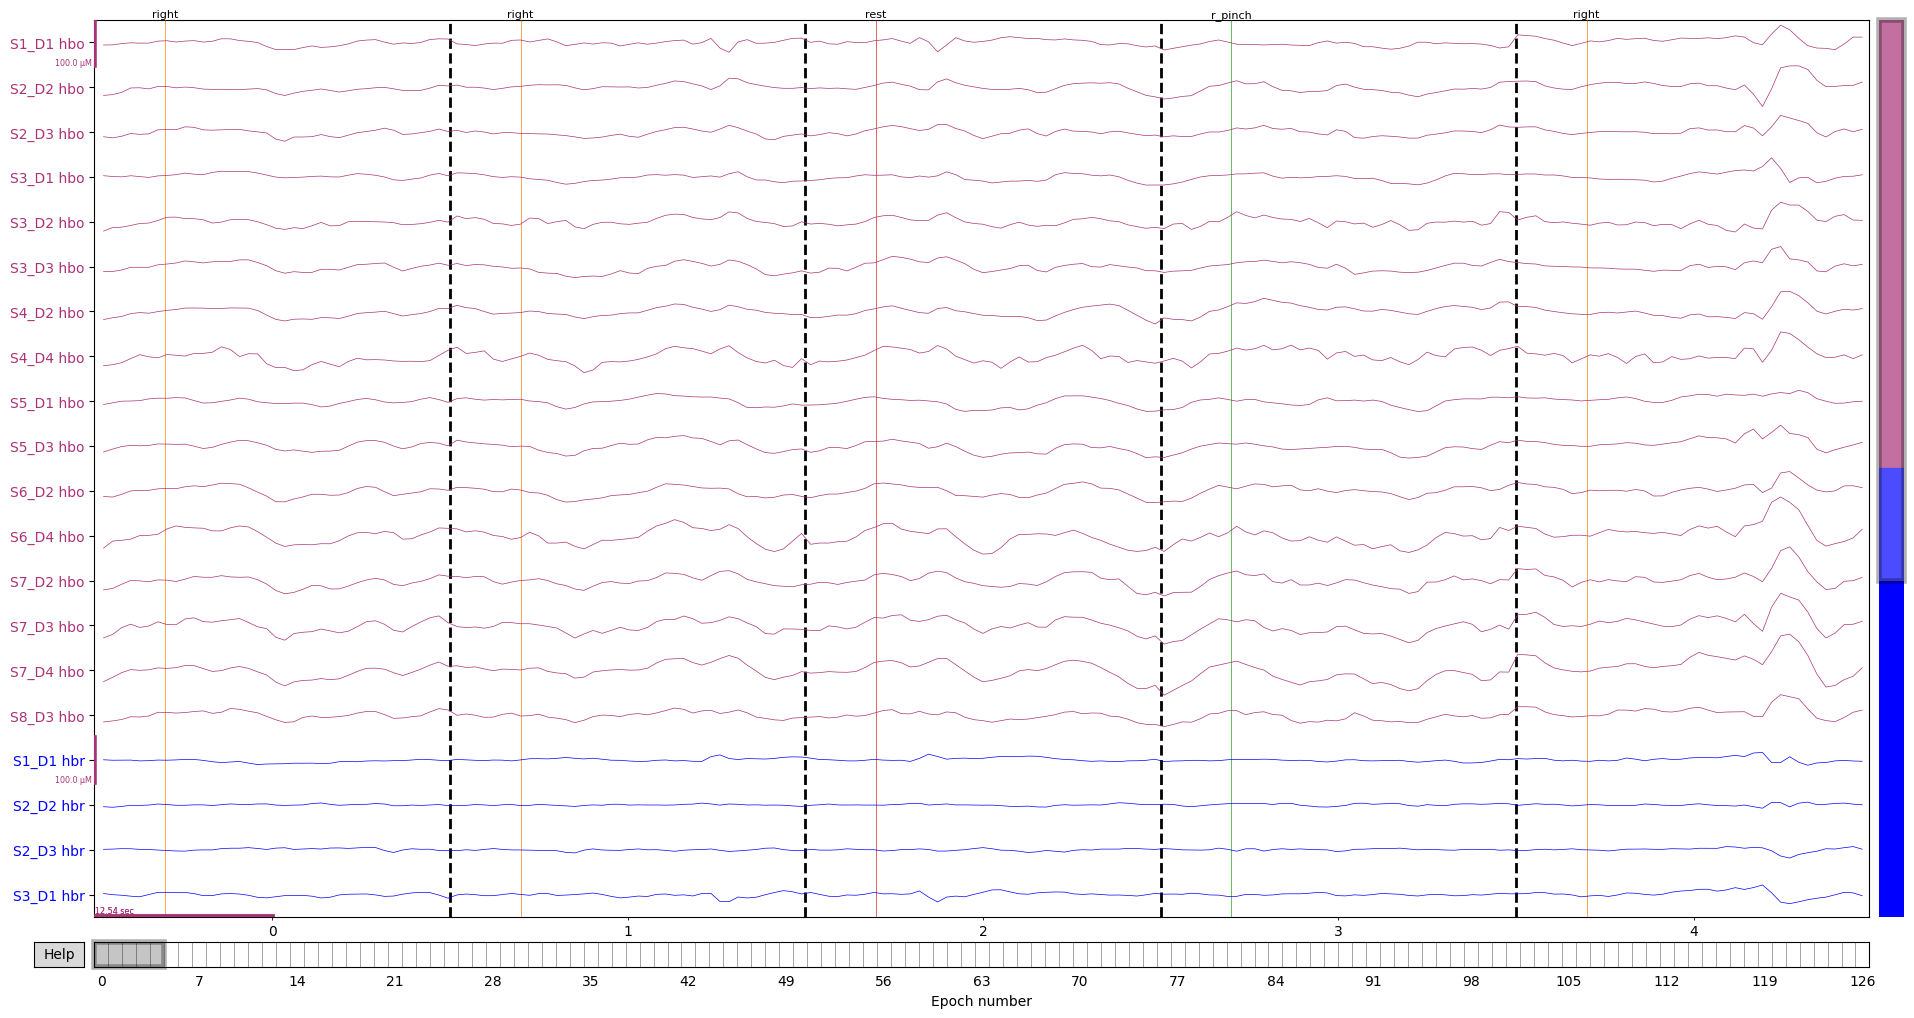

In [29]:
epochs.plot(n_epochs=5, n_channels=20, scalings=50e-6, events=epochs.events, event_id=epochs.event_id)
print()

Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"
combining channels using "mean"


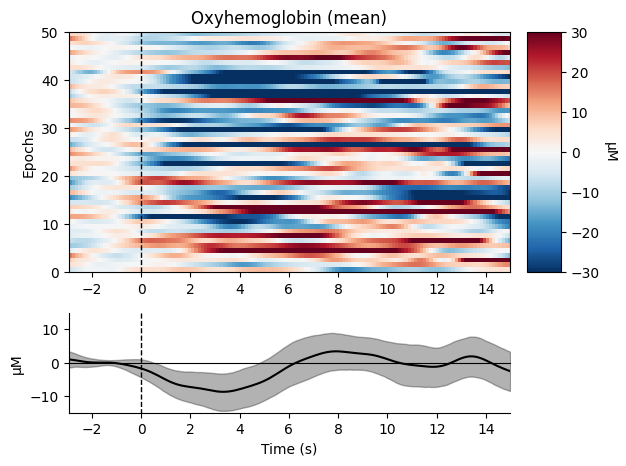

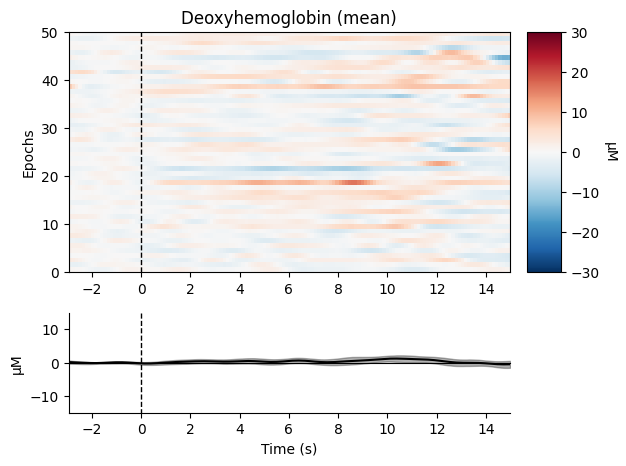

[<Figure size 640x480 with 3 Axes>, <Figure size 640x480 with 3 Axes>]

In [30]:
epochs['left','right'].copy().crop(-3,15).plot_image(combine='mean', vmin=-30, vmax=30,
                             ts_args=dict(ylim=dict(hbo=[-15, 15],
                                                    hbr=[-15, 15])))

Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"
combining channels using "mean"


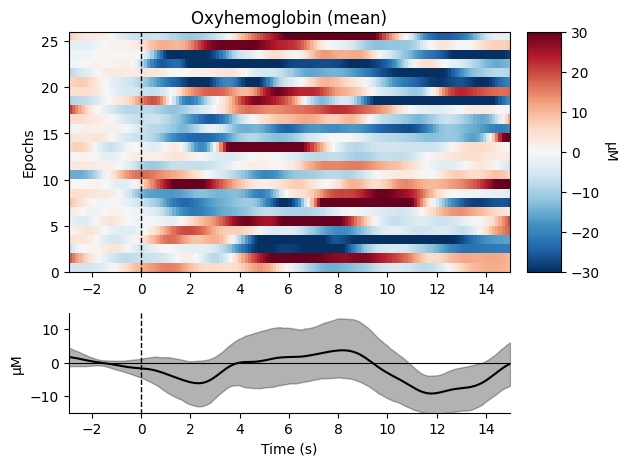

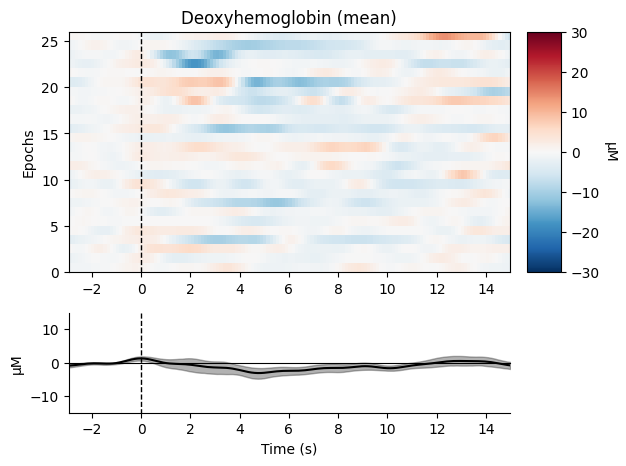

[<Figure size 640x480 with 3 Axes>, <Figure size 640x480 with 3 Axes>]

In [31]:
epochs['rest'].copy().crop(-3,15).plot_image(combine='mean', vmin=-30, vmax=30,
                             ts_args=dict(ylim=dict(hbo=[-15, 15],
                                                    hbr=[-15, 15])))

In [33]:
epochs.save('nirs_epo.fif', overwrite=True)

Overwriting existing file.
